In [25]:
import pandas as pd
import numpy as np
import tqdm
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import networkx as nx
tqdm.pandas()

In [2]:
df_edges = pd.read_csv('data/edges/edges.csv')

In [4]:
#this is depedent on Gephi so you need to first export the coords from there
df_positions = pd.read_csv('data/edges/nodes_marked_coords.csv')

In [6]:
df_combined = pd.concat([df_edges[['source', 'year']].rename(columns={'source': 'keyword'}),
                         df_edges[['target', 'year']].rename(columns={'target': 'keyword'})])

In [7]:
df_first_occurrence = df_combined.drop_duplicates(subset='keyword', keep='first')

In [11]:
sorted_groups = df_first_occurrence.groupby('year')

yearly_x = []
yearly_y = []
for year, group in tqdm(sorted_groups):
    keywords = group['keyword']

    x = 0
    y = 0
    valid_keywords = 0 

    for keyword in keywords:
        row = df_positions[df_positions['Id'] == keyword]
        if not row.empty:  # Check if the row exists
            x += row['X'].iloc[0]
            y += row['Y'].iloc[0]
            valid_keywords += 1

    # avoid division by zero
    if valid_keywords > 0:
        yearly_x.append(x / valid_keywords)
        yearly_y.append(y / valid_keywords)
    else:
        yearly_x.append(None)  # Append None if no valid keywords
        yearly_y.append(None)

  0%|          | 0/34 [00:00<?, ?it/s]

In [12]:
yearly_x

[-1450.2165068860759,
 -1221.3299435600002,
 -1097.6188008,
 -1012.3961345952384,
 -993.2663915441175,
 -1035.5914532931038,
 -980.7787093750001,
 -913.8158554181821,
 -855.439105897959,
 -784.1668507118641,
 -774.8622947222224,
 -653.4613726797385,
 -587.0725738315215,
 -492.739006255814,
 -426.99061425233634,
 -525.5530664464287,
 -486.2617528736842,
 -340.5189194049588,
 -301.53371281081075,
 -285.05149280999996,
 -202.72895874782594,
 -142.52566581081078,
 -22.5709285652174,
 62.899270202970314,
 129.8270503155737,
 285.7256156235743,
 457.5623397777775,
 653.0998712095246,
 759.029760026273,
 929.3999273156621,
 1024.6263655060397,
 1066.8044969668779,
 1121.1639753144204,
 1112.6578126574504]

In [17]:
#calculates the colors based on the gradient used in Gephi
gradient_path = 'visualizations/color gradient.png'
gradient_image = Image.open(gradient_path)
width, height = gradient_image.size
num_samples = 34

x_coords = [int(x) for x in np.linspace(0, width - 1, num_samples)]

y_middle = height // 2
gradient_colors = [gradient_image.getpixel((x, y_middle)) for x in x_coords]
normalized_colors = [tuple(channel / 255 for channel in color) for color in gradient_colors]

In [19]:
df_positions_sorted = df_positions.sort_values(by='X', ascending=True)

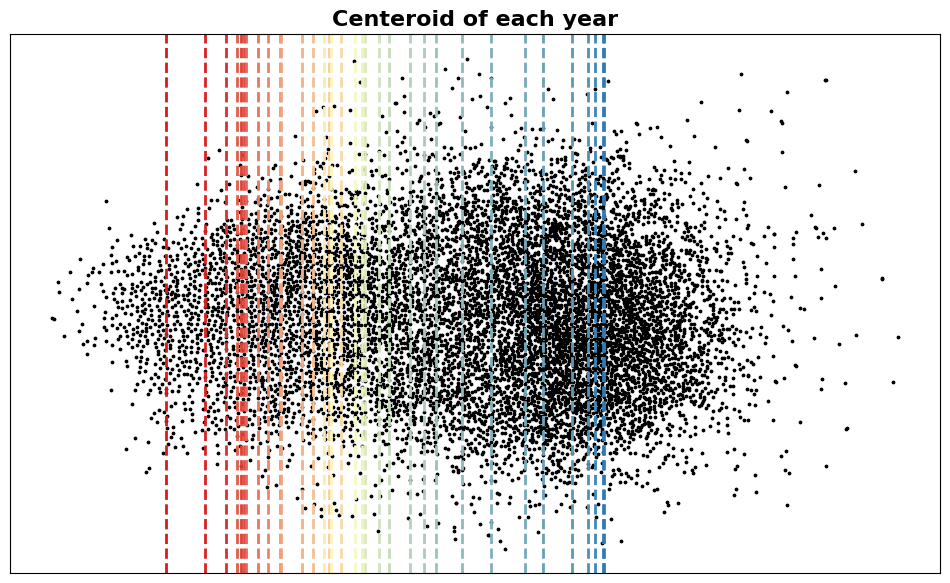

In [21]:
fig, ax = plt.subplots(figsize=(12, 7))

# nodes as a scatter plot
ax.scatter(df_positions_sorted['X'], df_positions_sorted['Y'], color='black', s=3)

# vertical line for each centerpoint
i = 0
for x in yearly_x:
    color = color = normalized_colors[i]
    ax.axvline(x=x, color=color, linestyle='--', linewidth=2)
    i+=1

ax.set_title('Centeroid of each year',fontsize=16, fontweight='bold')
ax.set_xticks([])
ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0)


plt.savefig('visualizations/center_points.png', bbox_inches='tight')
plt.show()

# Center using a centrality meassure

In [29]:
def calculate_central_nodes_per_year(df):
    results = []
    for year, group in tqdm(df.groupby('year')):
        G = nx.Graph()
        G.add_edges_from(zip(group['source'], group['target']))

        
        if nx.is_connected(G): #in case it is not connected take the largest component
            betweenness = nx.betweenness_centrality(G)
            closeness = nx.closeness_centrality(G)
        else:
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            
            betweenness = nx.betweenness_centrality(subgraph)
            closeness = nx.closeness_centrality(subgraph)

        central_betweenness_node = max(betweenness, key=betweenness.get)
        central_closeness_node = max(closeness, key=closeness.get)

        results.append({
            'year': year,
            'central_betweenness_node': central_betweenness_node,
            'betweenness_value': betweenness[central_betweenness_node],
            'central_closeness_node': central_closeness_node,
            'closeness_value': closeness[central_closeness_node]
        })
        
    return pd.DataFrame(results)


In [30]:
central_nodes_df = calculate_central_nodes_per_year(df_edges)

  0%|          | 0/34 [00:00<?, ?it/s]

In [31]:
# Merge positions with centrality meassures
result_closeness = pd.merge(
    central_nodes_df, 
    df_positions, 
    left_on='central_closeness_node', 
    right_on='Id',
    how='left'
)
result_betweenness = pd.merge(
    central_nodes_df, 
    df_positions, 
    left_on='central_betweenness_node', 
    right_on='Id',
    how='left'
)

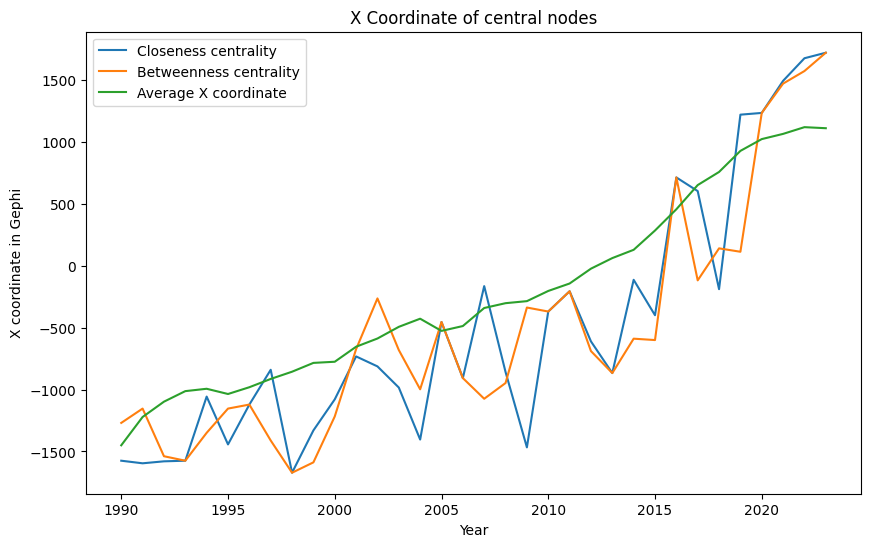

In [32]:
fig = plt.figure(figsize=(10, 6))

plt.plot(result_closeness['year'], result_closeness['X'], label='Closeness centrality')
plt.plot(result_betweenness['year'], result_betweenness['X'], label='Betweenness centrality')
plt.plot(result_betweenness['year'], yearly_x, label='Average X coordinate')

plt.title("X Coordinate of central nodes")
plt.xlabel("Year")
plt.ylabel("X coordinate in Gephi")
plt.legend()

plt.savefig('visualizations/coordinates.png', bbox_inches='tight')

plt.show()